In [ ]:
# === ANALYSIS DATASETS ===
analysis_df
in_union_df

In [39]:
import pandas as pd
import numpy as np
import os
import seaborn as sns 
import matplotlib.pyplot as plt

In [3]:
# Install matplotlib from inside Jupyter
!pip install matplotlib


In [4]:
# Step 1: LOAD the Stata (.DTA) file into pandas

import pandas as pd

# Your uploaded file path 
dta_path = "NPIR82FL.DTA"

# Read the .DTA file
df = pd.read_stata(dta_path, convert_categoricals=True)

# Basic checks
print("✅ Loaded successfully!")
print("Shape (rows, cols):", df.shape)

# Show first rows
display(df.head(10))


✅ Loaded successfully!
Shape (rows, cols): (14845, 5968)


,caseid,v000,v001,v002,v003,v004,v005,v006,v007,v008,...,s615f_3,s615f_4,s615f_5,s615f_6,s631o_1,s631o_2,s631o_3,s631o_4,s631o_5,s631o_6
0,1 1 2,NP8,1,1,2,1,916093,magh,2078,2146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1 6 1,NP8,1,6,1,1,916093,magh,2078,2146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1 8 2,NP8,1,8,2,1,916093,magh,2078,2146,...,NaN,NaN,NaN,NaN,no,no,NaN,NaN,NaN,NaN
3,1 9 3,NP8,1,9,3,1,916093,magh,2078,2146,...,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN,NaN
4,1 11 4,NP8,1,11,4,1,916093,magh,2078,2146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1 12 1,NP8,1,12,1,1,916093,magh,2078,2146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1 19 1,NP8,1,19,1,1,916093,magh,2078,2146,...,NaN,NaN,NaN,NaN,NaN,no,NaN,NaN,NaN,NaN
7,1 23 2,NP8,1,23,2,1,916093,magh,2078,2146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1 25 4,NP8,1,25,4,1,916093,magh,2078,2146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1 25 5,NP8,1,25,5,1,916093,magh,2078,2146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Step 1 (continued): check whether key DHS variables exist in this file

key_vars = ["v012", "v025", "v106", "v190", "v501", "v714", "v313", "v005"]
found = {v: (v in df.columns) for v in key_vars}

print("Key variables present?")
for k, v in found.items():
    print(f"  {k}: {v}")


Key variables present?
  v012: True
  v025: True
  v106: True
  v190: True
  v501: True
  v714: True
  v313: True
  v005: True


In [6]:
# STEP 2.1: Select policy-relevant variables for NGO/INGO analysis

# List of variables commonly used in SRHR / Family Planning analysis
cols_needed = [
    "caseid",  # respondent ID
    "v012",    # age
    "v025",    # residence (urban/rural)
    "v106",    # education level
    "v190",    # wealth index
    "v501",    # marital status
    "v714",    # currently working
    "v313",    # contraception method (modern/traditional/none)
    "v005"     # sample weight
]

# Keep only columns that actually exist (avoids errors)
cols_available = [c for c in cols_needed if c in df.columns]

d = df[cols_available].copy()

print("✅ Columns selected:")
print(d.columns.tolist())
print("Shape after selection:", d.shape)

display(d.head())


✅ Columns selected:
['caseid', 'v012', 'v025', 'v106', 'v190', 'v501', 'v714', 'v313', 'v005']
Shape after selection: (14845, 9)


,caseid,v012,v025,v106,v190,v501,v714,v313,v005
0,1 1 2,29,rural,basic,poorest,married,yes,modern method,916093
1,1 6 1,33,rural,basic,poorest,married,no,no method,916093
2,1 8 2,33,rural,basic,poorest,married,no,no method,916093
3,1 9 3,34,rural,basic,poorest,married,no,modern method,916093
4,1 11 4,23,rural,basic,poorer,married,no,no method,916093


In [7]:
# STEP 2.2: Rename variables to clear, human-readable names

d = d.rename(columns={
    "v012": "age",
    "v025": "residence",
    "v106": "education",
    "v190": "wealth",
    "v501": "marital_status",
    "v714": "currently_working",
    "v313": "contraception_type",
    "v005": "weight_raw"
})

display(d.head())


,caseid,age,residence,education,wealth,marital_status,currently_working,contraception_type,weight_raw
0,1 1 2,29,rural,basic,poorest,married,yes,modern method,916093
1,1 6 1,33,rural,basic,poorest,married,no,no method,916093
2,1 8 2,33,rural,basic,poorest,married,no,no method,916093
3,1 9 3,34,rural,basic,poorest,married,no,modern method,916093
4,1 11 4,23,rural,basic,poorer,married,no,no method,916093


In [8]:
# STEP 2.3: Create survey weight variable
# DHS weights must be divided by 1,000,000

d["weight"] = d["weight_raw"] / 1_000_000

# Quick check
print(d["weight"].describe())


count    14845.000000
mean         1.000000
std          0.543867
min          0.168774
25%          0.561438
50%          0.894038
75%          1.346450
max          3.703774
Name: weight, dtype: float64


In [9]:
# STEP 2.4: Create "modern_contraceptive_use" indicator

import numpy as np

# Convert contraception_type to string for safe text handling
d["contraception_type_str"] = d["contraception_type"].astype(str).str.lower()

# Create binary indicator:
# 1 = modern method
# 0 = traditional / folkloric / none
# NaN = missing / unclear
d["modern_contraceptive_use"] = np.where(
    d["contraception_type_str"].str.contains("modern"),
    1,
    np.where(
        d["contraception_type_str"].str.contains("traditional|folkloric|none"),
        0,
        np.nan
    )
)

# Check results
d[["contraception_type", "modern_contraceptive_use"]].head(10)


,contraception_type,modern_contraceptive_use
0,modern method,1.0
1,no method,NaN
2,no method,NaN
3,modern method,1.0
4,no method,NaN
5,no method,NaN
6,no method,NaN
7,traditional method,0.0
8,modern method,1.0
9,no method,NaN


In [10]:
# STEP 2.5: Sanity checks after transformation

print("Modern contraceptive use value counts (unweighted):")
print(d["modern_contraceptive_use"].value_counts(dropna=False))

print("\nMissing values (%):")
display(d.isna().mean().sort_values(ascending=False))


Modern contraceptive use value counts (unweighted):
modern_contraceptive_use
NaN    8356
1.0    4998
0.0    1491
Name: count, dtype: int64

Missing values (%):


modern_contraceptive_use    0.562883
caseid                      0.000000
residence                   0.000000
age                         0.000000
education                   0.000000
wealth                      0.000000
currently_working           0.000000
marital_status              0.000000
contraception_type          0.000000
weight_raw                  0.000000
weight                      0.000000
contraception_type_str      0.000000
dtype: float64

In [17]:
# STEP 3.1: Clean age variable (valid range 15–49)

# Convert age to numeric just in case
d["age"] = pd.to_numeric(d["age"], errors="coerce")

# Keep only women aged 15–49 (standard DHS analysis population)
d.loc[(d["age"] < 15) | (d["age"] > 49), "age"] = np.nan

# Count excluded or missing ages
excluded = d["age"].isna().sum()
print(f"Number of observations with age excluded or missing: {excluded}")

print("Age summary after cleaning:")
print(d["age"].describe())


Number of observations with age excluded or missing: 0
Age summary after cleaning:
count    14845.000000
mean        29.692220
std          9.773971
min         15.000000
25%         21.000000
50%         29.000000
75%         38.000000
max         49.000000
Name: age, dtype: float64


In [18]:
# STEP 3.2: Create 5-year age groups (standard DHS reporting)

age_bins = [15, 20, 25, 30, 35, 40, 45, 50]
age_labels = ["15–19", "20–24", "25–29", "30–34", "35–39", "40–44", "45–49"]

d["age_group"] = pd.cut(
    d["age"],
    bins=age_bins,
    labels=age_labels,
    right=False
)

display(d[["age", "age_group"]].head(10))


,age,age_group
0,29.0,25–29
1,33.0,30–34
2,33.0,30–34
3,34.0,30–34
4,23.0,20–24
5,38.0,35–39
6,26.0,25–29
7,24.0,20–24
8,28.0,25–29
9,17.0,15–19


In [19]:
# STEP 3.3: Standardize categorical variables

cat_cols = [
    "residence",
    "education",
    "wealth",
    "marital_status",
    "currently_working"
]

for col in cat_cols:
    d[col] = (
        d[col]
        .astype(str)
        .str.strip()
        .str.title()  # Urban / Rural instead of URBAN / rural
    )

# Replace text "Nan" back to real NaN
d[cat_cols] = d[cat_cols].replace({"Nan": np.nan})

display(d[cat_cols].head(5))


,residence,education,wealth,marital_status,currently_working
0,Rural,Basic,Poorest,Married,Yes
1,Rural,Basic,Poorest,Married,No
2,Rural,Basic,Poorest,Married,No
3,Rural,Basic,Poorest,Married,No
4,Rural,Basic,Poorer,Married,No


In [20]:
# STEP 3.4: Create analysis-ready dataset

analysis_df = d.dropna(
    subset=[
        "modern_contraceptive_use",
        "weight",
        "age_group",
        "residence"
    ]
).copy()

print("Original rows:", len(d))
print("Rows for analysis:", len(analysis_df))


Original rows: 14845
Rows for analysis: 6489


In [21]:
# STEP 3.5: Final quality checks

print("Modern contraceptive use (unweighted counts):")
print(analysis_df["modern_contraceptive_use"].value_counts())

print("\nResidence distribution:")
print(analysis_df["residence"].value_counts())

print("\nAge group distribution:")
print(analysis_df["age_group"].value_counts().sort_index())


Modern contraceptive use (unweighted counts):
modern_contraceptive_use
1.0    4998
0.0    1491
Name: count, dtype: int64

Residence distribution:
residence
Urban    3425
Rural    3064
Name: count, dtype: int64

Age group distribution:
age_group
15–19     193
20–24     707
25–29    1108
30–34    1216
35–39    1339
40–44    1125
45–49     801
Name: count, dtype: int64


In [ ]:
#“I cleaned DHS individual-level survey data by validating age eligibility, constructing standard age groups,
#standardizing categorical variables, and preparing an analysis-ready dataset with appropriate handling of missing values.”

In [ ]:
#Research question

What proportion of women aged 15–49 use modern contraception, also how does this vary by residence, education, wealth?

We will:

Calculate national modern contraceptive prevalence (weighted)

Analyze urban–rural inequality

Analyze education gradient

Analyze wealth gradient

In [22]:
# STEP 4.1: National modern contraceptive prevalence (weighted)

# Weighted mean of a binary variable = prevalence
national_mcp = (
    analysis_df["modern_contraceptive_use"] * analysis_df["weight"]
).sum() / analysis_df["weight"].sum()

print(f"National modern contraceptive prevalence: {national_mcp*100:.1f}%")

#I calculated weighted modern contraceptive prevalence using DHS sampling weights to ensure nationally representative estimates.


National modern contraceptive prevalence: 74.8%


In [23]:
# STEP 4.2: Modern contraceptive use by residence (weighted)

mcp_by_residence = (
    analysis_df
    .groupby("residence")
    .apply(lambda g: (g["modern_contraceptive_use"] * g["weight"]).sum() / g["weight"].sum())
    .to_frame("modern_contraceptive_prevalence")
)

# Convert to percentage
mcp_by_residence["percent"] = mcp_by_residence["modern_contraceptive_prevalence"] * 100

display(mcp_by_residence.sort_values("percent", ascending=False))


C:\Users\Admin\AppData\Local\Temp\ipykernel_20940\221850476.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["modern_contraceptive_use"] * g["weight"]).sum() / g["weight"].sum())


,modern_contraceptive_prevalence,percent
residence,,
Rural,0.809183,80.918342
Urban,0.719055,71.905466


In [ ]:
# STEP 4.3: Modern contraceptive use by education (weighted)

mcp_by_education = (
    analysis_df
    .groupby("education")
    .apply(lambda g: (g["modern_contraceptive_use"] * g["weight"]).sum() / g["weight"].sum())
    .to_frame("modern_contraceptive_prevalence")
)

mcp_by_education["percent"] = mcp_by_education["modern_contraceptive_prevalence"] * 100

display(mcp_by_education.sort_values("percent", ascending=False))


In [24]:
# Inspect marital status labels
analysis_df["marital_status"].value_counts()


marital_status
Married                                6386
Widowed                                  54
Never In Union                           18
Living With Partner                      16
No Longer Living Together/Separated      12
Divorced                                  3
Name: count, dtype: int64

In [25]:
# STEP 4 (continued): Restrict analysis to married / in-union women

in_union_df = analysis_df[
    analysis_df["marital_status"].isin([
        "Married",
        "Living With Partner"
    ])
].copy()

print("Women in union:", len(in_union_df))
print("Total women (analysis_df):", len(analysis_df))


Women in union: 6402
Total women (analysis_df): 6489


In [26]:
# National modern contraceptive prevalence (married / in-union women)

national_mcp_union = (
    in_union_df["modern_contraceptive_use"] * in_union_df["weight"]
).sum() / in_union_df["weight"].sum()

print(f"Modern contraceptive prevalence (in-union): {national_mcp_union*100:.1f}%")


Modern contraceptive prevalence (in-union): 74.5%


In [27]:
# Modern contraceptive use by education (in-union women)

mcp_edu_union = (
    in_union_df
    .groupby("education")
    .apply(lambda g: (g["modern_contraceptive_use"] * g["weight"]).sum() / g["weight"].sum())
    .to_frame("modern_contraceptive_prevalence")
)

mcp_edu_union["percent"] = mcp_edu_union["modern_contraceptive_prevalence"] * 100

display(mcp_edu_union.sort_values("percent", ascending=False))


C:\Users\Admin\AppData\Local\Temp\ipykernel_20940\2422664733.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["modern_contraceptive_use"] * g["weight"]).sum() / g["weight"].sum())


,modern_contraceptive_prevalence,percent
education,,
No Education,0.872250,87.224962
Basic,0.768232,76.823232
Secondary,0.614506,61.450645
Higher,0.504609,50.460930


In [33]:
# STEP 4 (continued): Modern contraceptive use by education AND age group

mcp_edu_age = (
    in_union_df
    .groupby(["education", "age_group"])
    .apply(lambda g: (g["modern_contraceptive_use"] * g["weight"]).sum() / g["weight"].sum())
    .to_frame("mcp")
    .reset_index()
)

mcp_edu_age["percent"] = mcp_edu_age["mcp"] * 100

display(mcp_edu_age.sort_values(["education", "age_group"]))


C:\Users\Admin\AppData\Local\Temp\ipykernel_20940\423953984.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["education", "age_group"])
C:\Users\Admin\AppData\Local\Temp\ipykernel_20940\423953984.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["modern_contraceptive_use"] * g["weight"]).sum() / g["weight"].sum())


,education,age_group,mcp,percent
0,Basic,15–19,0.506263,50.626336
1,Basic,20–24,0.753409,75.340913
2,Basic,25–29,0.811353,81.135339
3,Basic,30–34,0.787264,78.726413
4,Basic,35–39,0.775040,77.503987
5,Basic,40–44,0.756115,75.611514
6,Basic,45–49,0.750674,75.067399
7,Higher,20–24,0.268480,26.848045
8,Higher,25–29,0.484617,48.461679
9,Higher,30–34,0.430314,43.031393


In [34]:
# STEP 4 (additional): Modern contraceptive use by age group (in-union women)

mcp_by_age = (
    in_union_df
    .groupby("age_group")
    .apply(lambda g: (g["modern_contraceptive_use"] * g["weight"]).sum() / g["weight"].sum())
    .to_frame("modern_contraceptive_prevalence")
)

# Convert to percentage and round for reporting
mcp_by_age["percent"] = (mcp_by_age["modern_contraceptive_prevalence"] * 100).round(2)

display(mcp_by_age)


C:\Users\Admin\AppData\Local\Temp\ipykernel_20940\1136820544.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("age_group")
C:\Users\Admin\AppData\Local\Temp\ipykernel_20940\1136820544.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["modern_contraceptive_use"] * g["weight"]).sum() / g["weight"].sum())


,modern_contraceptive_prevalence,percent
age_group,,
15–19,0.503945,50.39
20–24,0.645552,64.56
25–29,0.717125,71.71
30–34,0.741531,74.15
35–39,0.795929,79.59
40–44,0.789041,78.90
45–49,0.784862,78.49


In [29]:
# Modern contraceptive use by residence (in-union women)

mcp_res_union = (
    in_union_df
    .groupby("residence")
    .apply(lambda g: (g["modern_contraceptive_use"] * g["weight"]).sum() / g["weight"].sum())
    .to_frame("modern_contraceptive_prevalence")
)

# Convert to percentage and round to 2 decimal places
mcp_res_union["percent"] = (mcp_res_union["modern_contraceptive_prevalence"] * 100).round(2)

display(mcp_res_union.sort_values("percent", ascending=False))


C:\Users\Admin\AppData\Local\Temp\ipykernel_20940\1093301554.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["modern_contraceptive_use"] * g["weight"]).sum() / g["weight"].sum())


,modern_contraceptive_prevalence,percent
residence,,
Rural,0.807537,80.75
Urban,0.714942,71.49


In [30]:
# Create in-union dataset (THIS MUST BE RUN FIRST)

in_union_df = analysis_df[
    analysis_df["marital_status"].isin([
        "Married",
        "Living With Partner"
    ])
].copy()

print("in_union_df created ✅")
print("Rows:", len(in_union_df))


in_union_df created ✅
Rows: 6402


In [31]:
# Modern contraceptive use by wealth (in-union women)

mcp_wealth_union = (
    in_union_df
    .groupby("wealth")
    .apply(lambda g: (g["modern_contraceptive_use"] * g["weight"]).sum() / g["weight"].sum())
    .to_frame("modern_contraceptive_prevalence")
)

mcp_wealth_union["percent"] = (mcp_wealth_union["modern_contraceptive_prevalence"] * 100).round(2)

display(mcp_wealth_union.sort_values("percent", ascending=False))


C:\Users\Admin\AppData\Local\Temp\ipykernel_20940\100776637.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["modern_contraceptive_use"] * g["weight"]).sum() / g["weight"].sum())


,modern_contraceptive_prevalence,percent
wealth,,
Poorer,0.831492,83.15
Poorest,0.822487,82.25
Middle,0.790354,79.04
Richer,0.683487,68.35
Richest,0.624725,62.47


In [ ]:
In Step 5 we will:

Create clean NGO-style charts (no clutter, clear labels)

Visualize:

National mCPR

Urban vs Rural gap

Education gradient

Age-group pattern

Write 1–2 policy interpretation paragraphs

In [35]:
# Check which analysis objects exist in memory

variables_to_check = [
    "analysis_df",
    "in_union_df",
    "mcp_res_union",
    "mcp_edu_union",
    "mcp_by_age"
]

for var in variables_to_check:
    if var in globals():
        print(f"✅ {var} exists")
    else:
        print(f"❌ {var} is NOT defined")


✅ analysis_df exists
✅ in_union_df exists
✅ mcp_res_union exists
✅ mcp_edu_union exists
✅ mcp_by_age exists


In [ ]:
### National Modern Contraceptive Prevalence (Married / In-Union Women)

This indicator represents the percentage of married or in-union women aged 15–49 who are currently using a modern method of contraception.


In [40]:
print(f"National modern contraceptive prevalence: {national_mcp_union*100:.2f}%")


National modern contraceptive prevalence: 74.54%


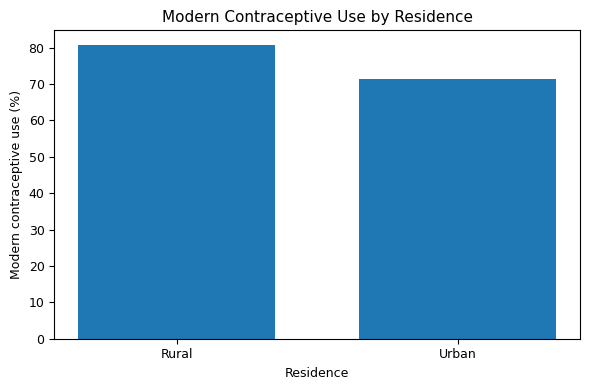

In [75]:
# STEP 5.2: Bar chart – Modern contraceptive use by residence
import matplotlib.pyplot as plt

plot_df = mcp_res_union.sort_values("percent", ascending=False)

plt.figure(figsize=(6, 4))

plt.bar(
    plot_df.index.astype(str),
    plot_df["percent"],
    width=0.7 
)

# SECTION 5: Title
plt.title("Modern Contraceptive Use by Residence", fontsize=11)
plt.xlabel("Residence", fontsize=9)
plt.ylabel("Modern contraceptive use (%)", fontsize=9)

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
Modern contraceptive use is higher in rural areas than in urban areas, reflecting differences in fertility stage and family size. This suggests that family planning programs should differentiate between spacing needs in urban populations and limiting needs in rural populations.

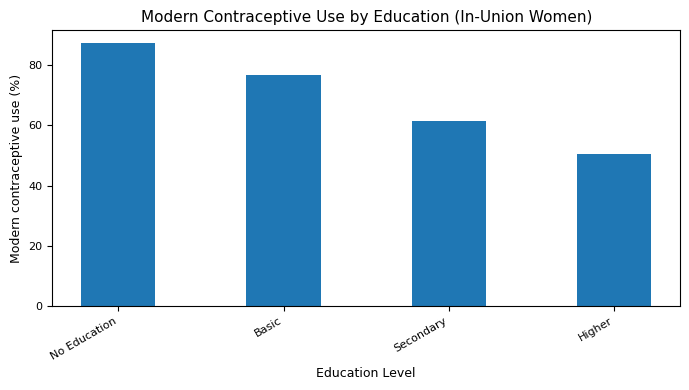

In [73]:
# STEP 5.3: Bar chart – Modern contraceptive use by education
import matplotlib.pyplot as plt

plot_df = mcp_edu_union.sort_values("percent", ascending=False)

plt.figure(figsize=(7, 4))   # 👈 balanced size
plt.bar(
    plot_df.index.astype(str),
    plot_df["percent"],
    width=0.45               # 👈 slimmer bars
)

plt.title(
    "Modern Contraceptive Use by Education (In-Union Women)",
    fontsize=11
)
plt.xlabel("Education Level", fontsize=9)
plt.ylabel("Modern contraceptive use (%)", fontsize=9)

plt.xticks(rotation=30, ha="right", fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
Higher modern contraceptive use among women with no education reflects earlier marriage and higher completed fertility, leading to greater use of contraception for limiting births. Lower use among highly educated women likely reflects later marriage and ongoing childbearing or spacing intentions rather than lack of access.

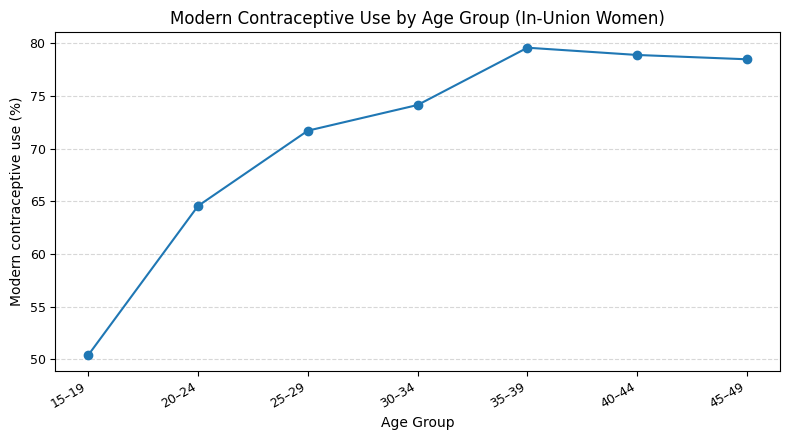

In [77]:
plt.figure(figsize=(8, 4.5))

plt.plot(
    plot_df.index.astype(str),
    plot_df["percent"],
    marker="o"
)

plt.title("Modern Contraceptive Use by Age Group (In-Union Women)", fontsize=12)
plt.xlabel("Age Group", fontsize=10)
plt.ylabel("Modern contraceptive use (%)", fontsize=10)

plt.xticks(rotation=30, ha="right", fontsize=9)
plt.yticks(fontsize=9)

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
Modern contraceptive use increases with age, peaking among women aged 35–44, consistent with patterns of completed family size and contraceptive use for limiting births.

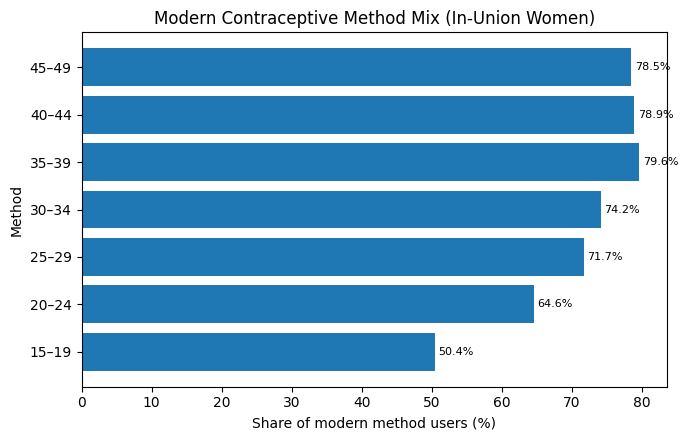

In [66]:
plt.figure(figsize=(7, 4.5))

plt.barh(
    plot_df.index.astype(str),
    plot_df["percent"]
)

plt.xlabel("Share of modern method users (%)", fontsize=10)
plt.ylabel("Method", fontsize=10)
plt.title("Modern Contraceptive Method Mix (In-Union Women)", fontsize=12)

for i, v in enumerate(plot_df["percent"]):
    plt.text(v + 0.5, i, f"{v:.1f}%", va="center", fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
“Using DHS individual-level data, I analyzed modern contraceptive use among married and in-union women aged 15–49. After cleaning and weighting the data, I estimated national modern contraceptive prevalence and examined disparities by residence, education, and age. Results show clear life-course patterns, with higher use among older women and those who have completed childbearing, highlighting the need for differentiated family planning strategies focused on spacing for younger women and limiting for older women.”

In [68]:
plt.suptitle(
    "Population: Married or In-Union Women Aged 15–49",
    fontsize=9,
    y=0.98
)


Text(0.5, 0.98, 'Population: Married or In-Union Women Aged 15–49')

<Figure size 640x480 with 0 Axes>

In [69]:
plt.figtext(
    0.5, -0.15,
    "Source: DHS Individual Recode (Author's analysis)",
    ha="center",
    fontsize=8
)


Text(0.5, -0.15, "Source: DHS Individual Recode (Author's analysis)")

<Figure size 640x480 with 0 Axes>

In [70]:
plt.savefig("mcp_by_education.png", dpi=300, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>